In [1]:
!pip install -q pyro-ppl torch torchvision
import numpy as np
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import datetime
import os
import matplotlib.gridspec as gridspec
from matplotlib import pyplot
import matplotlib.pyplot as plt
from scipy.stats import norm
import pyro
import torch
import matplotlib
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms

You should consider upgrading via the 'pip install --upgrade pip' command.


## Get the MNIST data

In [2]:
data = datasets.MNIST('./data', train=True, download=True)

# We only select the digits 0, 1, and 2 and only the first 100 of each of these
# digits

selector = np.array([], dtype=int)
for i in [5, 6, 7]:
    selector = np.concatenate((selector, np.where(data.targets == i)[0][:100]))
data.data = data.data[selector, :, :]
data.targets = data.targets[selector]

# Binarize the data
data.data[data.data<128] = 0
data.data[data.data>=128] = 1

data.data = data.data.type(torch.float)
data.data = data.data.reshape(300,-1)

0it [00:00, ?it/s]

9920512it [00:02, 4234144.30it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 102616.47it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 1486439.08it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 38683.86it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


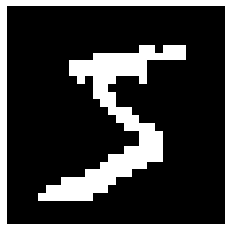

In [3]:
def display_image(x):
    plt.axis('off')
    plt.imshow(x.reshape((28, 28)), cmap="gray")

toy_image = data.data[0,:]
display_image(toy_image)

## The model

In [4]:
def model(data, no_attributes, no_latent):

    w = pyro.sample("w", dist.Normal(torch.zeros(no_attributes, no_latent)*0., 1.).to_event(2))
    with pyro.plate('local', len(data)):
        z = pyro.sample("z", dist.Normal(torch.zeros(no_latent, dtype=torch.float), 1.).to_event(1))
        x = pyro.sample("x", dist.Binomial(logits = torch.mm(z, torch.t(w))).to_event(1), obs=data)

    return x

## The guide

In [5]:
def guide(data, no_attributes, no_latent):

    z_loc = pyro.param("z_loc", torch.zeros((len(data), no_latent), dtype=torch.float))
    z_scale = pyro.param("z_scale", torch.ones((len(data), no_latent), dtype=torch.float),
                         constraint=constraints.positive)
    with pyro.plate('local', len(data)):
        pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

    w_loc = pyro.param("w_loc", torch.zeros(no_attributes, no_latent, dtype=torch.float))
    w_scale = pyro.param("w_scale", torch.ones(no_attributes, no_latent, dtype=torch.float), constraint=constraints.positive)

    pyro.sample("w", dist.Normal(w_loc, w_scale).to_event(2))

## Perform learning

In [6]:
def train(svi, data, no_attr, no_latent):
    # initialize loss accumulator

    epoch_loss = svi.step(data, no_attr, no_latent)

    # return epoch loss
    normalizer_train = len(data)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

[epoch 000] average training loss: 211179.5938
[epoch 100] average training loss: 60882.3459
[epoch 200] average training loss: 55537.5741
[epoch 300] average training loss: 55444.1440
[epoch 400] average training loss: 55426.0995


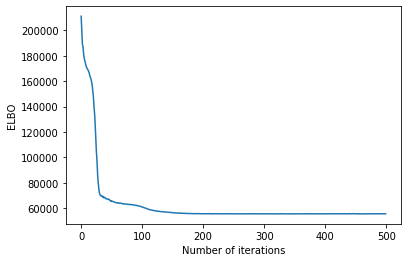

In [7]:
# Run options
LEARNING_RATE = 1.0e-1

# Run only for a single iteration for testing
NUM_EPOCHS = 500

#train_loader = setup_data_loader(batch_size=300)

# Model specifications
no_latent = 2
no_attributes = 28 * 28

# clear param store
pyro.clear_param_store()

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
train_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):

    loss = svi.step(data.data, no_attributes, no_latent)
    train_elbo.append(loss)
    if (epoch % 100) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, loss))

plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()


### Learned parameters

In [8]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

z_loc tensor([[-1.3855, -1.2135],
        [-1.7946, -1.0688],
        [-1.9523, -1.2850],
        [-1.5796, -0.9012],
        [-1.7256, -1.1355],
        [-1.7765, -1.5793],
        [-1.9070, -2.0256],
        [-0.8003, -2.2449],
        [-1.8434, -1.0780],
        [-1.8018, -1.1280],
        [-1.5426, -1.2037],
        [-0.9835, -1.4310],
        [-1.8187, -1.3394],
        [-1.3077, -1.3879],
        [-1.8632, -0.7558],
        [-1.7119, -1.0825],
        [-0.6393, -1.4867],
        [-1.6105, -1.3154],
        [-0.8049, -1.2124],
        [-1.5078, -1.4762],
        [-0.8466, -3.1151],
        [-0.8427, -1.0264],
        [-1.7600, -1.2486],
        [-1.1340, -0.9065],
        [-1.2836, -1.1194],
        [-0.9500, -2.0139],
        [-1.3296, -1.4483],
        [-1.7867, -1.5917],
        [-1.2092, -1.8332],
        [-1.5168, -2.3758],
        [-1.5634, -1.7241],
        [-1.4719, -1.6733],
        [-1.9823, -1.5330],
        [-2.1056, -1.7074],
        [-1.6349, -1.5640],
        [-2.18

### Distribution in latent space

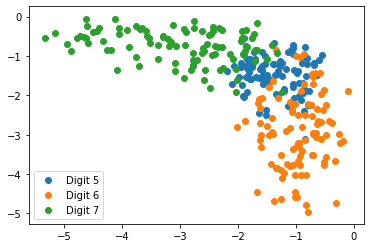

In [9]:
z_loc = pyro.param("z_loc").detach().numpy()
legends = ["Digit 5", "Digit 6", "Digit 7"]
for idx, i in enumerate([5,6,7]):
    plt.scatter(z_loc[data.targets.numpy()==i,0], z_loc[data.targets.numpy()==i,1], label=legends[idx])
plt.legend()
plt.show()